## Classical RBM training on the OptDigits Dataset for reconstruction and classification
Developed by: Jose Pinilla

In [1]:
# Required packages
import qaml
import torch
torch.manual_seed(36) # For deterministic weights

import matplotlib.pyplot as plt
import torchvision.transforms as torch_transforms

In [2]:
################################# Hyperparameters ##############################
M,N = SHAPE = (8,8)
DATA_SIZE = N*M
EPOCHS = 35
BATCH_SIZE = 1024
SUBCLASSES = [0,1,2,3,5,6,7,8]

# Stochastic Gradient Descent
learning_rate = 0.1
weight_decay = 1e-4
momentum = 0.5


Using downloaded and verified file ./data/OptDigits\raw\optdigits.tra
Using downloaded and verified file ./data/OptDigits\raw\optdigits.tes


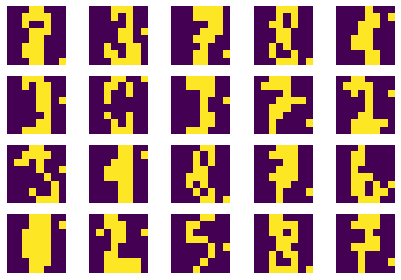

In [3]:
#################################### Input Data ################################
opt_train = qaml.datasets.OptDigits(root='./data/',train=True,download=True,
                                        transform=qaml.datasets.ToSpinTensor())
qaml.datasets._subset_classes(opt_train,SUBCLASSES)
qaml.datasets._embed_labels(opt_train,encoding='one_hot',scale=255)
train_sampler = torch.utils.data.RandomSampler(opt_train,replacement=False)
train_loader = torch.utils.data.DataLoader(opt_train,BATCH_SIZE,sampler=train_sampler)


opt_test = qaml.datasets.OptDigits(root='./data/',train=False,download=True,
                                       transform=qaml.datasets.ToSpinTensor())
qaml.datasets._subset_classes(opt_test,SUBCLASSES)
set_label,get_label = qaml.datasets._embed_labels(opt_test,encoding='one_hot',
                                                  scale=255,setter_getter=True)

test_sampler = torch.utils.data.RandomSampler(opt_test,replacement=False)
test_loader = torch.utils.data.DataLoader(opt_test,sampler=test_sampler)

# Visualize
fig, axs = plt.subplots(4, 5)
for ax, (img, label) in zip(axs.flat, test_loader):
    ax.matshow(img.squeeze())
    # ax.set_title(int(label))
    ax.axis('off')
plt.tight_layout()

In [4]:
################################# Model Definition #############################
VISIBLE_SIZE = DATA_SIZE
HIDDEN_SIZE = 16

# Specify model with dimensions
rbm = qaml.nn.RBM(VISIBLE_SIZE,HIDDEN_SIZE,'SPIN')

# Set up optimizer
optimizer = torch.optim.SGD(rbm.parameters(),lr=learning_rate,
                            weight_decay=weight_decay,momentum=momentum)

# Set up training mechanisms
beta = 1.0
gibbs_sampler = qaml.sampler.GibbsNetworkSampler(rbm,BATCH_SIZE,beta=beta)
CD = qaml.autograd.ContrastiveDivergence

In [5]:
################################## Model Training ##############################
# Set the model to training mode
rbm.train()
err_log = []
kl_div_log = []
accuracy_log = []
b_log = [rbm.b.detach().clone().numpy()]
c_log = [rbm.c.detach().clone().numpy()]
W_log = [rbm.W.detach().clone().numpy().flatten()]
for t in range(EPOCHS):
    kl_div = torch.Tensor([0.])
    epoch_error = torch.Tensor([0.])
    for img_batch, labels_batch in train_loader:
        input_data = img_batch.flatten(1)

        # Positive Phase
        v0, p_h0 = gibbs_sampler(input_data.detach(),k=0)
        # Negative Phase
        p_vk, p_hk = gibbs_sampler(v0.detach(),k=1)

        # Reconstruction error from Contrastive Divergence
        err = CD.apply(gibbs_sampler,(v0,p_h0),(p_vk,p_hk),*rbm.parameters())

        # Do not accumulated gradients
        optimizer.zero_grad()

        # Compute gradients
        err.backward()

        # Update parameters
        optimizer.step()

        #Accumulate error for this epoch
        epoch_error  += err
        kl_div += qaml.perf.free_energy_smooth_kl(rbm,v0,gibbs_sampler.sample(p_vk))
    # KL-Divergence
    kl_div_log.append(kl_div.item())
    print(f"Epoch {t} KL-Divergence = {kl_div.item()}")
    # Error Log
    b_log.append(rbm.b.detach().clone().numpy())
    c_log.append(rbm.c.detach().clone().numpy())
    W_log.append(rbm.W.detach().clone().numpy().flatten())
    err_log.append(epoch_error.item())
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")

    ############################## CLASSIFICATION ##################################
    count = 0
    for test_data, test_label in opt_test:
        input_data =  test_data.flatten(1)
        mask = set_label(torch.ones_like(test_data),0).flatten()
        v_recon,h_recon = gibbs_sampler.reconstruct(input_data,mask=mask,k=5)
        label_pred = get_label(v_recon.view(-1,*SHAPE))
        if label_pred.argmax() == get_label(test_data).argmax():
            count+=1
    accuracy_log.append(count/len(opt_test))
    print(f"Testing accuracy: {count}/{len(opt_test)} ({count/len(opt_test):.2f})")


Epoch 0 KL-Divergence = 23.3824405670166
Epoch 0 Reconstruction Error = 65.29471588134766
Testing accuracy: 236/1436 (0.16)
Epoch 1 KL-Divergence = 0.8435183167457581
Epoch 1 Reconstruction Error = 13.34655475616455
Testing accuracy: 437/1436 (0.30)
Epoch 2 KL-Divergence = 0.5156794190406799
Epoch 2 Reconstruction Error = 7.021389961242676
Testing accuracy: 597/1436 (0.42)
Epoch 3 KL-Divergence = 0.4358593225479126
Epoch 3 Reconstruction Error = 4.4518280029296875
Testing accuracy: 675/1436 (0.47)
Epoch 4 KL-Divergence = 0.6604816317558289
Epoch 4 Reconstruction Error = 4.192144870758057
Testing accuracy: 716/1436 (0.50)
Epoch 5 KL-Divergence = 0.6127815246582031
Epoch 5 Reconstruction Error = 4.336852550506592
Testing accuracy: 856/1436 (0.60)
Epoch 6 KL-Divergence = 0.7558823823928833
Epoch 6 Reconstruction Error = 3.6474623680114746
Testing accuracy: 950/1436 (0.66)
Epoch 7 KL-Divergence = 0.5868592262268066
Epoch 7 Reconstruction Error = 3.9668362140655518
Testing accuracy: 960/143

Text(0.5, 0, 'Epoch')

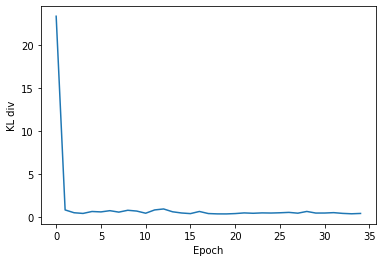

In [6]:
############################ MODEL VISUALIZATION ###############################

# KL Divergence graph
fig, ax = plt.subplots()
ax.plot(kl_div_log)
plt.ylabel("KL div")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

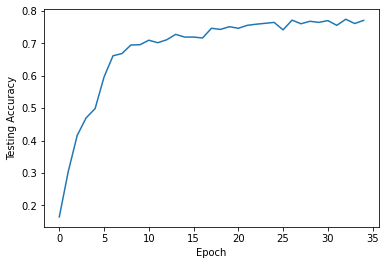

In [7]:
# Testing accuracy graph
fig, ax = plt.subplots()
ax.plot(accuracy_log)
plt.ylabel("Testing Accuracy")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

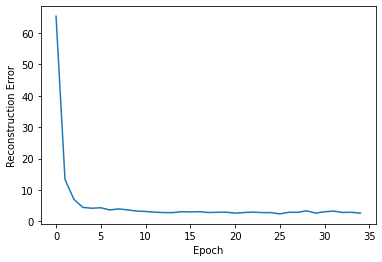

In [8]:
# L1 error graph
fig, ax = plt.subplots()
ax.plot(err_log)
plt.ylabel("Reconstruction Error")
plt.xlabel("Epoch")

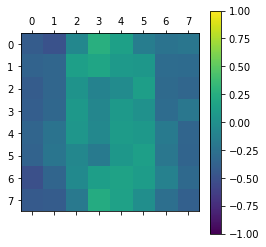

In [9]:
########################## VISUALIZE WEIGHTS ###################################
plt.matshow(rbm.b.detach()[:DATA_SIZE].view(*SHAPE), cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()



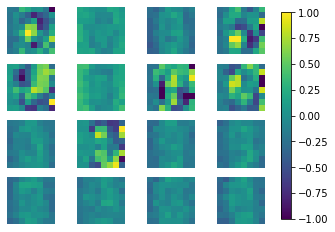

In [10]:
########################## VISUALIZE WEIGHTS ###################################
fig,axs = plt.subplots(HIDDEN_SIZE//4,4)
for i,ax in enumerate(axs.flat):
    weight_matrix = rbm.W[i].detach()[:DATA_SIZE].view(*SHAPE)
    ms = ax.matshow(weight_matrix, cmap='viridis', vmin=-1, vmax=1)
    ax.axis('off')
cbar = fig.colorbar(ms, ax=axs.ravel().tolist(), shrink=0.95)